## Notebook for extracting pupil data etc

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
# general imports
import sys
import pickle
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import copy
from tqdm import tqdm
import matplotlib.image as mpimg
import popoff
import pop_off_functions as pof
import pop_off_plotting as pop

from Session import Session, SessionLite, build_flu_array_single
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel


In [3]:
## Load sessions
pas = PoolAcrossSessions(remove_targets=False, subsample_sessions=False,
                         remove_toosoon=True, pre_start=-0.51)

for ss in pas.sessions.values():
    _ = pop.normalise_raster_data(session=ss, sort_neurons=False, filter_150_stim=False)
    

long post time
long post time
long post time
long post time
long post time
Mouse RL070, run 29  registered no-lick hit. changed to too soon
long post time
long post time
Mouse RL117, run 29  registered no-lick hit. changed to too soon
Mouse RL117, run 29  registered no-lick hit. changed to too soon
long post time
long post time
long post time
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time


In [4]:
## Load pop var
reg_list = ['s1', 's2']
cov_dicts = {x: {} for x in reg_list}
super_covar_df_dict = {}
for i_reg, reg in enumerate(reg_list):
    print(reg)
    for i_lm, linear_model in tqdm(enumerate(pas.linear_models)):
        name = pas.sessions[i_lm].mouse + '_' + str(pas.sessions[i_lm].run_number)
        # if name in ['RL117_29', 'RL117_30']:
        cov_dicts[reg][i_lm] = pof.get_covariates(linear_model, reg, hitmiss_only=False,
                                                filter_150=False)

    super_covar_df_dict[reg] = pof.create_df_from_cov_dicts(cov_dicts=cov_dicts[reg], 
                                                  zscore_list=['variance_cell_rates', 'mean_pre'])

0it [00:00, ?it/s]

s1


11it [03:29, 19.07s/it]
0it [00:00, ?it/s]

s2


11it [02:54, 15.90s/it]


In [6]:
pas.sessions

{0: instance Mouse J064, run 10 of Session class,
 1: instance Mouse J064, run 11 of Session class,
 2: instance Mouse J064, run 14 of Session class,
 3: instance Mouse RL070, run 28 of Session class,
 4: instance Mouse RL070, run 29 of Session class,
 5: instance Mouse RL117, run 26 of Session class,
 6: instance Mouse RL117, run 29 of Session class,
 7: instance Mouse RL117, run 30 of Session class,
 8: instance Mouse RL123, run 22 of Session class,
 9: instance Mouse RL116, run 32 of Session class,
 10: instance Mouse RL116, run 33 of Session class}

In [7]:
# ## put your path to your vape repo here 
# path_to_vape = os.path.expanduser('~/Documents/code/Vape/')
# popoff_path = '/home/jrowland/Documents/code/pop-off/scripts/'

# # Bit hacky but oh well
# sys.path.append(path_to_vape)
# sys.path.append(os.path.join(path_to_vape, 'utils'))
# sys.path.append(popoff_path)

# from utils.utils_funcs import d_prime

In [5]:
# df_pupil_mice = pd.DataFrame({'mouse': ['RL117', 'RL117'], 'run_number': [29, 30],
#                               'filename_prefix': ['2021-03-09_RL117', '2021-03-10_RL117']})
df_pupil_mice = pd.DataFrame({'mouse': ['RL117', 'RL117', 'RL123'], 'run_number': [29, 30, 22],
                              'filename_prefix': ['2021-03-09_RL117', '2021-03-10_RL117', None]})
df_pupil_mice['signature'] = df_pupil_mice['mouse'] + '_' + df_pupil_mice['run_number'].astype(str)
df_pupil_mice

,mouse,run_number,filename_prefix,signature
0,RL117,29,2021-03-09_RL117,RL117_29
1,RL117,30,2021-03-10_RL117,RL117_30
2,RL123,22,None,RL123_22


In [6]:

def consecutive(data, stepsize=1):
    '''https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array'''
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def handle_outliers(data_arr=None, bool_good_dp=None, bool_bad_dp=None):
    '''bool_good_dp: inds of ones to keep, bad vice versa'''
    data_arr = copy.deepcopy(data_arr)
    if bool_bad_dp is None and bool_good_dp is not None:
        tmp_bool_arr = np.ones(len(data_arr), dtype='bool')
        tmp_bool_arr[bool_good_dp] = False 

        nan_inds = np.where(np.isnan(data_arr))[0]
        tmp_bool_arr[nan_inds] = True
        tmp_bool_arr = np.where(tmp_bool_arr)[0]
        list_of_outlier_intervals = consecutive(tmp_bool_arr)
    elif bool_good_dp is None and bool_bad_dp is not None:
        print('WARNING: no nan correction yet!!')
        list_of_outlier_intervals = consecutive(bool_bad_dp)
    for interval in list_of_outlier_intervals:
        start_dp = interval[0] - 1
        end_dp = interval[-1] + 1
        n_dps = len(interval)

        if end_dp > len(data_arr) - 1:
            print('last ind is outlier')
            # diff_start = np.diff(data_arr[start_dp - 1:start_dp + 1])
            # linear_interpolation = np.linspace(data_arr[start_dp], data_arr[stdict_pupil_data[signature]['area_array']art_dp] + diff_start * n_dps, n_dps + 1)
            # data_arr[start_dp:end_dp] = np.squeeze(linear_interpolation)
            data_arr[start_dp:end_dp] = data_arr[start_dp]

        elif start_dp == -1:
            print('first ind is outlier')
            data_arr[:end_dp] = data_arr[end_dp]

        else:
            linear_interpolation = np.linspace(data_arr[start_dp], data_arr[end_dp], n_dps + 2)
            assert linear_interpolation[0] == data_arr[start_dp], f'{start_dp, end_dp, data_arr[start_dp], data_arr[end_dp], linear_interpolation[0]}'
            assert linear_interpolation[-1] == data_arr[end_dp]
            data_arr[start_dp:end_dp + 1] = linear_interpolation
        
    return data_arr
    
def load_pupil_data(df_pupil_mice, dir='/home/tplas/data/mice'):
    dict_pupil_data = {signature: {} for signature in df_pupil_mice['signature']}

    for i_sess, signature in enumerate(dict_pupil_data.keys()):
        print(signature)
        if signature != 'RL123_22':
            basic_filename = os.path.join(dir, 'pupil_data_2022-11-11/', df_pupil_mice[df_pupil_mice['signature'] == signature]['filename_prefix'].iloc[0])
            dict_pupil_data[signature]['area_array'] = np.load(basic_filename + '_AreaArray.npy')
            dict_pupil_data[signature]['binary_score'] = np.load(basic_filename + '_BinaryScore.npy')
            dict_pupil_data[signature]['r2_distance'] = np.load(basic_filename + '_r2Distance.npy')
            dict_pupil_data[signature]['binary_score'] = np.concatenate((dict_pupil_data[signature]['binary_score'], np.where(np.isnan(dict_pupil_data[signature]['area_array']))[0]))
            dict_pupil_data[signature]['binary_score'] = np.sort(np.unique(dict_pupil_data[signature]['binary_score'] ))
            dict_pupil_data[signature]['area_array_corrected'] = handle_outliers(data_arr=dict_pupil_data[signature]['area_array'],
                                                                                bool_good_dp=dict_pupil_data[signature]['binary_score'])
        
        if signature == 'RL117_29':
            new_fn = os.path.join(dir, 'pupil_data_2022-11-28/2021-03-09_RL117_pupil_2021-03-09-145620_croppedMinimallyDaskAnnotated0-12_FixedCenter65.85_allFrames_resArray.npy')
        elif signature == 'RL117_30':
            new_fn = os.path.join(dir, 'pupil_data_2022-11-28/2021-03-10_RL117_pupil_2021-03-10-164145_croppedMinimallyDaskAnnotated0-10_FixedCenter55.75_allFrames_resArray.npy')
        elif signature == 'RL123_22':
            new_fn = os.path.join(dir, 'pupil_data_2022-11-28/2021-03-10_RL123_pupil_2021-03-10-185442_croppedMinimallyDaskAnnotated0-10_FixedCenter_allFrames_resArray.npy')

        res_array = np.load(new_fn, 'r')
        a_array = res_array[:,1]
        filtered_a_array = scipy.ndimage.median_filter(a_array, size=6)  # eliminate outliers
        dict_pupil_data[signature]['filtered_a_array'] = filtered_a_array
        if 'area_array_corrected' in dict_pupil_data[signature].keys():
            assert dict_pupil_data[signature]['filtered_a_array'].shape == dict_pupil_data[signature]['area_array_corrected'].shape

    return dict_pupil_data



dict_pupil_data = load_pupil_data(df_pupil_mice=df_pupil_mice)




RL117_29
first ind is outlier
RL117_30
RL123_22


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


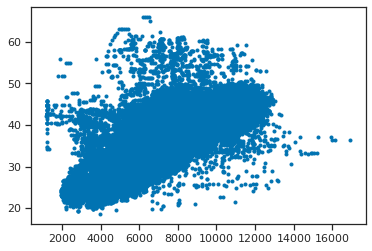

In [7]:

# plt.plot(dict_pupil_data['RL117_29']['area_array_corrected'], 
#          dict_pupil_data['RL117_29']['area_array'], '.')

plt.plot(dict_pupil_data['RL117_29']['area_array_corrected'] ,
         dict_pupil_data['RL117_29']['filtered_a_array'], '.')



In [8]:
## Load run 
def load_run(mouse, run_number, base_path):
    pkl_path = os.path.join(base_path, mouse, f'run{run_number}.pkl')
    print(pkl_path)
    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
    
    return run

def get_dict_runs(df_pupil_mice):

    dict_runs = {} 
    for i_sess in range(len(df_pupil_mice)):
        print(df_pupil_mice['signature'].iloc[i_sess])
        dict_runs[df_pupil_mice['signature'].iloc[i_sess]] = load_run(mouse=df_pupil_mice['mouse'].iloc[i_sess],
                                                                      run_number=df_pupil_mice['run_number'].iloc[i_sess],
                                                                      base_path='/home/tplas/data/mice/runs/')
    return dict_runs

dict_runs = get_dict_runs(df_pupil_mice=df_pupil_mice)

RL117_29
/home/tplas/data/mice/runs/RL117/run29.pkl
RL117_30
/home/tplas/data/mice/runs/RL117/run30.pkl
RL123_22
/home/tplas/data/mice/runs/RL123/run22.pkl


In [9]:
def filter_frames_first_pass(run, pupil):
    idx_imaged = np.isin(run.frame_clock, run.paqio_frames)
    assert sum(idx_imaged) == run.flu.shape[1]
    assert len(idx_imaged) == len(pupil)
    pupil = pupil[idx_imaged]
    return pupil

def find_session_for_pupil(sess_dict, signature='J064_29'):
    mouse = signature.split('_')[0]
    run_number = int(signature.split('_')[1])

    for i_s, sess in sess_dict.items():
        if mouse == sess.mouse and run_number == sess.run_number:
            return sess

    print('NO session found!')


for signature in dict_pupil_data.keys():
    for name_p in ['area_array', 'r2_distance', 'area_array_corrected', 'filtered_a_array']:
        if name_p in dict_pupil_data[signature].keys():
            dict_pupil_data[signature][name_p] = filter_frames_first_pass(run=dict_runs[signature], 
                                                                      pupil=dict_pupil_data[signature][name_p])

In [10]:
## I am James Rowland and this is my invention:

for signature in df_pupil_mice['signature']:
    corresponding_sess = find_session_for_pupil(sess_dict=pas.sessions, signature=signature)
    
    dict_runs[signature].pupil = np.expand_dims(dict_pupil_data[signature]['filtered_a_array'], 0)  # add to run so we can use build_flu_array_single 
    dict_pupil_data[signature]['pupil_size'] = np.squeeze(build_flu_array_single(run=dict_runs[signature], use_pupil=True, 
                                                                        pre_frames=60, post_frames=120))
                                                                    #   pre_frames=corresponding_sess.pre_frames, 
                                                                    #   post_frames=corresponding_sess.post_frames))  # use session pre_frames & post_frames here

    dict_pupil_data[signature]['pupil_size'] = dict_pupil_data[signature]['pupil_size'][corresponding_sess.nonnan_trials, :]
    print(f'Loaded pupil with shape (trials x time points) {dict_pupil_data[signature]["pupil_size"].shape}')
    assert np.isnan(dict_pupil_data[signature]['pupil_size']).sum() == 0


Loaded pupil with shape (trials x time points) (260, 180)
Loaded pupil with shape (trials x time points) (192, 180)
Loaded pupil with shape (trials x time points) (177, 180)


## Final fig:


In [11]:
## prep
dict_signature_to_session_ind = {'RL117_29': 6, 'RL117_30': 7, 'RL123_22': 8}
## Normalise pupil size across sessions:
preframes_pupil = 60
slice_prestim_period_popvar = slice(45, 60)

baseline_dict = {}
for iplot, signature in enumerate(['RL117_29', 'RL117_30', 'RL123_22']):
    baseline_dict[signature] = {}
    pupil_arr = dict_pupil_data[signature]['pupil_size']
    session = find_session_for_pupil(sess_dict=pas.sessions, signature=signature)
    
    ## Average of hit average & miss average
    # for tt in ['hit', 'miss']:
    #     curr_sel = pupil_arr[session.outcome==tt, :]
    #     baseline_dict[signature][tt] = np.mean(curr_sel[:, :preframes_pupil])
    # baseline_dict[signature]['average_hm'] = (baseline_dict[signature]['hit'] + baseline_dict[signature]['miss']) / 2 

    ## Average of all hit & miss trials:
    curr_sel = pupil_arr[np.isin(session.outcome, ['hit', 'miss']), :]
    baseline_dict[signature]['average_hm'] = np.mean(curr_sel[:, :preframes_pupil])

concat_pupilsize = {}
concat_pupilsize_for_test = {}
concat_pupilsize_for_scatter = {}
concat_popvar = {}
popvar_persess = {}
for tt in ['hit', 'miss']:
    popvar_persess[tt] = {}
    for iplot, signature in enumerate(['RL117_29', 'RL117_30', 'RL123_22']):
        pupil_arr = dict_pupil_data[signature]['pupil_size']
        time_arr = np.linspace(-2, 4 - 1/30, pupil_arr.shape[1])
        session = find_session_for_pupil(sess_dict=pas.sessions, signature=signature)
        curr_sel = pupil_arr[session.outcome == tt, :]
        curr_sel = curr_sel - baseline_dict[signature]['average_hm']  # baseline 

        if iplot == 0:  # concatenate across sessions:
            concat_pupilsize[tt] = curr_sel 
        else:
            concat_pupilsize[tt] = np.concatenate((concat_pupilsize[tt], curr_sel), axis=0)

        concat_pupilsize_for_test[tt] = concat_pupilsize[tt][:, :preframes_pupil].mean(1)
        concat_pupilsize_for_scatter[tt] = concat_pupilsize[tt][:, slice_prestim_period_popvar].mean(1)
        ## pop var:
        i_s = dict_signature_to_session_ind[signature]
        pop_var_arr = cov_dicts['s1'][i_s]['variance_cell_rates']  # retrieve previously calculated pop var 
        curr_pop_var = pop_var_arr[session.outcome == tt]
        popvar_persess[tt][signature] = curr_pop_var
        if iplot == 0:  # concatenate across essions
            concat_popvar[tt] = curr_pop_var 
        else:
            concat_popvar[tt] = np.concatenate((concat_popvar[tt], curr_pop_var), axis=0)
pupil_im = mpimg.imread('/home/tplas/repos/popping-off/figures/screenshots_pupil_segmentation.png')

Pearson r for miss (0.013368982588787815, 0.8823626911673474)
Pearson r for hit (0.20694296178904317, 0.0021318264246042466)
Corr of scatter plots across all sessions and trial types:  (0.12431735291977886, 0.02128304639450494)
ttest GA dynamics pre-stim Ttest_indResult(statistic=-1.0481055915315485, pvalue=0.29533225302920046)
RL117_29 Ttest_indResult(statistic=-1.9517470463916333, pvalue=0.0530696483483295)
RL117_30 Ttest_indResult(statistic=0.8498713716554892, pvalue=0.3974681109936056)
RL123_22 Ttest_indResult(statistic=-1.047080303659299, pvalue=0.2974442686048535)


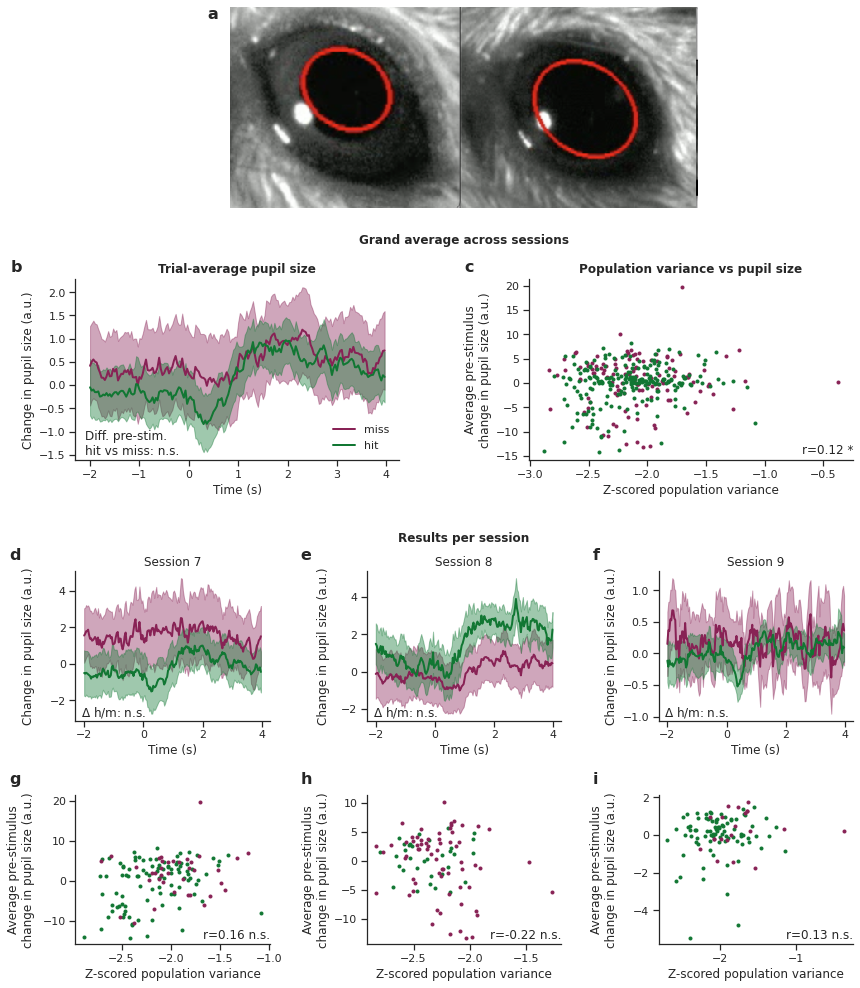

In [20]:
## fig
verbose = 1
save_fig = False 

fig = plt.figure(constrained_layout=False, figsize=(12, 14))
gs_screenshot = fig.add_gridspec(nrows=1, ncols=1, top=0.98, bottom=0.78, left=0.1, right=0.9)
gs_ga = fig.add_gridspec(nrows=1, ncols=2, top=0.71, bottom=0.53, left=0.05, right=0.95, wspace=0.4)
gs_ind = fig.add_gridspec(nrows=2, ncols=3, top=0.42, bottom=0.05, left=0.05, right=0.95, wspace=0.5, hspace=0.5)


## Screenshot
ax_screenshot = fig.add_subplot(gs_screenshot[0])
ax_screenshot.imshow(pupil_im, interpolation='none')
pop.naked(ax_screenshot)

ax_dyn = fig.add_subplot(gs_ga[0])
ax_scatter = fig.add_subplot(gs_ga[1])
colors = {'hit': '#117733', 'miss': '#882255'}

## Grand average:
for tt in ['miss', 'hit']:
    ## Dynamics:
    ax_dyn.plot(time_arr, concat_pupilsize[tt].mean(0), linewidth=2, color=colors[tt], label=tt)
    ci_95 = concat_pupilsize[tt].std(0) / np.sqrt(concat_pupilsize[tt].shape[0]) * 1.96
    ax_dyn.fill_between(x=time_arr, y1=concat_pupilsize[tt].mean(0) - ci_95, 
                    y2=concat_pupilsize[tt].mean(0) + ci_95, color=colors[tt], alpha=0.4)
   
    ## Scatter:
    ax_scatter.plot(concat_popvar[tt], concat_pupilsize_for_scatter[tt], '.', color=colors[tt])
    corr = scipy.stats.pearsonr(concat_pupilsize_for_scatter[tt], concat_popvar[tt])
    if verbose > 0:
        print(f'Pearson r for {tt}', scipy.stats.pearsonr(concat_pupilsize_for_scatter[tt], concat_popvar[tt]))

ax_dyn.set_title(f'Trial-average pupil size', fontdict={'weight': 'bold'})
ax_dyn.set_xlabel('Time (s)')
ax_dyn.set_ylabel('Change in pupil size (a.u.)')
ax_dyn.legend(loc='lower right', frameon=False)
pop.despine(ax_dyn)

ax_scatter.set_xlabel('Z-scored population variance')
ax_scatter.set_ylabel('Average pre-stimulus\nchange in pupil size (a.u.)')
pop.despine(ax_scatter)

## Tests:
corr_both_tts = scipy.stats.pearsonr(np.concatenate((concat_pupilsize_for_scatter['hit'], concat_pupilsize_for_scatter['miss'])), 
                                                             np.concatenate((concat_popvar['hit'], concat_popvar['miss'])))
if verbose > 0:
    print(f'Corr of scatter plots across all sessions and trial types: ', corr_both_tts)
ax_scatter.annotate(s='r={:.2f}'.format(np.round(corr_both_tts[0], 2)) + f' {pop.asterisk_p(corr_both_tts[1])}',
                          xy=(1, 0.04), xycoords='axes fraction', ha='right')
ax_scatter.set_title(f'Population variance vs pupil size', fontdict={'weight': 'bold'})
ttest_hit_vs_miss_pupil_prestim = scipy.stats.ttest_ind(concat_pupilsize_for_test['hit'], concat_pupilsize_for_test['miss'], alternative='two-sided')
if verbose > 0:
    print('ttest GA dynamics pre-stim', ttest_hit_vs_miss_pupil_prestim)
ax_dyn.annotate(s=f'Diff. pre-stim.\nhit vs miss: {pop.asterisk_p(ttest_hit_vs_miss_pupil_prestim[1])}', xy=(0.03, 0.03), xycoords='axes fraction')


## Individual sessions:
ax_dyn_ind = {x: fig.add_subplot(gs_ind[0, x]) for x in range(3)}
ax_scat_ind = {x: fig.add_subplot(gs_ind[1, x]) for x in range(3)}
for iplot, signature in enumerate(['RL117_29', 'RL117_30', 'RL123_22']):
    ## Dynamics:
    curr_ax = ax_dyn_ind[iplot]
    pupil_arr = dict_pupil_data[signature]['pupil_size']
    pupil_arr = pupil_arr - baseline_dict[signature]['average_hm']
    session = find_session_for_pupil(sess_dict=pas.sessions, signature=signature)
    time_arr = np.linspace(-2, 4 - 1/30, pupil_arr.shape[1])
    
    curr_sel_test = {}
    curr_sel_scatter = {}
    
    for tt in ['miss', 'hit']:
        curr_sel = pupil_arr[session.outcome==tt, :]

        curr_ax.plot(time_arr, curr_sel.mean(0), linewidth=2, color=colors[tt], label=tt)
        ci_95 = curr_sel.std(0) / np.sqrt(curr_sel.shape[0]) * 1.96
        curr_ax.fill_between(x=time_arr, y1=curr_sel.mean(0) - ci_95, 
                             y2=curr_sel.mean(0) + ci_95, color=colors[tt], alpha=0.4)

        curr_sel_test[tt] = curr_sel[:, :preframes_pupil].mean(1)  
        curr_sel_scatter[tt] = curr_sel[:, slice_prestim_period_popvar].mean(1)  # 500 ms pre-stim like pop var
    ttest_prestim =  scipy.stats.ttest_ind(curr_sel_test['hit'], curr_sel_test['miss'], alternative='two-sided')
    if verbose > 0:
        print(signature, ttest_prestim)
    curr_ax.annotate(s=r"$\Delta$" + f' h/m: {pop.asterisk_p(ttest_prestim[1])}', xy=(0.03, 0.03), xycoords='axes fraction')
    curr_ax.set_title(pop.translate_session(pas.sessions[dict_signature_to_session_ind[signature]]))
    curr_ax.set_xlabel('Time (s)')
    curr_ax.set_ylabel('Change in pupil size (a.u.)')
    pop.despine(curr_ax)

    ## Scatter:
    curr_ax = ax_scat_ind[iplot]
    for tt in ['hit', 'miss']:
        curr_popvar = popvar_persess[tt][signature]
        corr = scipy.stats.pearsonr(curr_popvar,  curr_sel_scatter[tt])

        curr_ax.plot(curr_popvar, curr_sel_scatter[tt], '.', color=colors[tt], label=tt)
    curr_ax.set_xlabel('Z-scored population variance')
    curr_ax.set_ylabel('Average pre-stimulus\nchange in pupil size (a.u.)')
    curr_ax.annotate(s='r={:.2f}'.format(np.round(corr[0], 2)) + f' {pop.asterisk_p(corr[1])}',
                          xy=(1, 0.04), xycoords='axes fraction', ha='right')
    pop.despine(curr_ax)

ax_dyn_ind[1].text(s='Grand average across sessions', x=np.mean(ax_dyn_ind[1].get_xlim()), y=23, fontdict={'weight': 'bold', 'ha': 'center'})
ax_dyn_ind[1].text(s='Results per session', x=np.mean(ax_dyn_ind[1].get_xlim()), y=7, fontdict={'weight': 'bold', 'ha': 'center'})
fig.align_ylabels([ax_dyn, ax_dyn_ind[0], ax_scat_ind[0]])
fig.align_ylabels([ax_dyn_ind[1], ax_scat_ind[1]])
fig.align_ylabels([ax_dyn_ind[2], ax_scat_ind[2]])

letters = 'bcdefghi'
ax_screenshot.annotate(s='a', xy=(-0.05, 1), xycoords='axes fraction',  weight='bold', size=16, va='top')
ax_dyn.annotate(s=letters[0], xy=(-0.2, 1.04), xycoords='axes fraction',  weight='bold', size=16)
ax_scatter.annotate(s=letters[1], xy=(-0.2, 1.04), xycoords='axes fraction',  weight='bold', size=16)
for ii in range(3):
    ax_dyn_ind[ii].annotate(s=letters[ii + 2], xy=(-0.34, 1.08), xycoords='axes fraction', weight='bold', size=16)
    ax_scat_ind[ii].annotate(s=letters[ii + 5], xy=(-0.34, 1.08), xycoords='axes fraction',  weight='bold', size=16)

if save_fig:
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/Supplementary_Figure14.pdf', bbox_inches='tight')